# Import Dataset

In [1]:
import pandas as pd # Data manipulation tool

# Upload csv file to Google Colab
from google.colab import files
uploaded = files.upload()

Saving player_reviews_overall_V2_Build_Model.csv to player_reviews_overall_V2_Build_Model.csv


In [2]:
# Load the file after uploading (Google Colab)
df = pd.read_csv("player_reviews_overall_V2_Build_Model.csv")

In [1]:
import pandas as pd # Data manipulation tool

# Upload csv file (Visual Studio)
df = pd.read_csv(r"c:\Users\jiunj\Documents\Campus Document\Year 3\FYP\FYP NULL\Dataset\player_reviews_overall_V2_Build_Model.csv")

# Pre-processing

## Check Column Data Type

In [2]:
print(df.dtypes)

app_name                  object
review_text               object
review_score               int64
review_length              int64
preprocess_review_text    object
cluster                    int64
dtype: object


## Remove Unwanted Column

In [3]:
df = df.drop(columns=['app_name'])
df = df.drop(columns=['review_score'])
df = df.drop(columns=['review_length'])

## Ensure The "review_text" is str Data Type and to List

In [4]:
texts_cnn_ltsm = df['review_text'].astype(str).tolist()
texts_nb_lr = df['preprocess_review_text'].astype(str).tolist()
labels = df['cluster'].tolist()

In [5]:
from collections import Counter
# Print Distribution
label_counts = Counter(labels)
print("Label Distribution:", label_counts)

Label Distribution: Counter({1: 57358, 7: 8035, 2: 7654, 0: 7653, 3: 7160, 4: 6027, 5: 3412, 6: 2701})


## Tokenization

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer

# --- RNN/LSTM Tokenization Process ---
# Parameters
max_vocab = 10000
max_len = 155  # Adjust based on review length

# Tokenize text
tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(texts_cnn_ltsm)
sequences = tokenizer.texts_to_sequences(texts_cnn_ltsm)
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# --- Naive Bayes/Logistic Regression Vectorization Process ---
# Set the maximum of important word to be keep
vectorizer = TfidfVectorizer(max_features=10000)
# Vectorize the text
X_tfidf = vectorizer.fit_transform(texts_nb_lr)


## Data Spliting

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np

# RNN/LSTM Data Splitting Process
x = np.array(padded)
y = np.array(labels)
x_train_rnn_ltsm, x_test_rnn_ltsm, y_train_rnn_ltsm, y_test_rnn_ltsm = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Naive Bayes/Logistic Regression Data Splitting Process
x_train_nb_lr, x_test_nb_lr, y_train_nb_lr, y_test_nb_lr = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
from collections import Counter
label_counts = Counter(y_train_rnn_ltsm)
print("Y Train Label Distribution:", label_counts)
label_counts = Counter(y_test_rnn_ltsm)
print("Y Test Label Distribution:", label_counts)

Y Train Label Distribution: Counter({np.int64(1): 45886, np.int64(7): 6428, np.int64(2): 6123, np.int64(0): 6122, np.int64(3): 5728, np.int64(4): 4822, np.int64(5): 2730, np.int64(6): 2161})
Y Test Label Distribution: Counter({np.int64(1): 11472, np.int64(7): 1607, np.int64(2): 1531, np.int64(0): 1531, np.int64(3): 1432, np.int64(4): 1205, np.int64(5): 682, np.int64(6): 540})


## Random Under Sampling

In [9]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Initialize RandomUnderSampler
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply random under-sampling to the training data (RNN/LSTM)
x_train_rnn_ltsm_resampled, y_train_rnn_ltsm_resampled = under_sampler.fit_resample(x_train_rnn_ltsm, y_train_rnn_ltsm)

# Apply random under-sampling to the training data (Naive Bayes/Logistic Regression)
x_train_nb_lr_resampled, y_train_nb_lr_resampled = under_sampler.fit_resample(x_train_nb_lr, y_train_nb_lr)

# Print class distribution before and after under-sampling
print(f"Original class distribution (train - RNN/LSTM): {Counter(y_train_rnn_ltsm)}")
print(f"Resampled class distribution (train - RNN/LSTM): {Counter(y_train_rnn_ltsm_resampled)}")

print(f"Original class distribution (train - Naive Bayes/Logistic Regression): {Counter(y_train_nb_lr)}")
print(f"Resampled class distribution (train - Naive Bayes/Logistic Regression): {Counter(y_train_nb_lr_resampled)}")

Original class distribution (train - RNN/LSTM): Counter({np.int64(1): 45886, np.int64(7): 6428, np.int64(2): 6123, np.int64(0): 6122, np.int64(3): 5728, np.int64(4): 4822, np.int64(5): 2730, np.int64(6): 2161})
Resampled class distribution (train - RNN/LSTM): Counter({np.int64(0): 2161, np.int64(1): 2161, np.int64(2): 2161, np.int64(3): 2161, np.int64(4): 2161, np.int64(5): 2161, np.int64(6): 2161, np.int64(7): 2161})
Original class distribution (train - Naive Bayes/Logistic Regression): Counter({np.int64(1): 45886, np.int64(7): 6428, np.int64(2): 6123, np.int64(0): 6122, np.int64(3): 5728, np.int64(4): 4822, np.int64(5): 2730, np.int64(6): 2161})
Resampled class distribution (train - Naive Bayes/Logistic Regression): Counter({np.int64(0): 2161, np.int64(1): 2161, np.int64(2): 2161, np.int64(3): 2161, np.int64(4): 2161, np.int64(5): 2161, np.int64(6): 2161, np.int64(7): 2161})


# Build LTSM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

lstm_model = Sequential()

# Embedding layer
lstm_model.add(Embedding(input_dim=10000, output_dim=128, input_length=155))

# Add Fully Connected Layer (Input, Hidden, Output Layer)
lstm_model.add(LSTM(100, return_sequences=True)) # Hidden Layer 1
lstm_model.add(Dropout(0.5)) # Dropout 1
lstm_model.add(LSTM(100, return_sequences=True)) # Hidden Layer 2
lstm_model.add(Dropout(0.5)) # Dropout 2
lstm_model.add(LSTM(100, return_sequences=False))  # Hidden Layer 3
lstm_model.add(Dropout(0.5)) # Dropout 3

# Output layer for 8-class classification
lstm_model.add(Dense(8, activation='softmax'))  # softmax for multi-class

# Compile model
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build Model
LTSM_History = lstm_model.fit(x_train_rnn_ltsm_resampled, y_train_rnn_ltsm_resampled, epochs=10, batch_size=32, validation_data=(x_test_rnn_ltsm, y_test_rnn_ltsm))

Epoch 1/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - accuracy: 0.1239 - loss: 2.0824 - val_accuracy: 0.0803 - val_loss: 2.0681
Epoch 2/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.1232 - loss: 2.0814 - val_accuracy: 0.0765 - val_loss: 2.0894
Epoch 3/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 36s 34ms/step - accuracy: 0.1243 - loss: 2.0805 - val_accuracy: 0.0765 - val_loss: 2.0543
Epoch 4/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.1243 - loss: 2.0805 - val_accuracy: 0.0270 - val_loss: 2.0712
Epoch 5/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.1216 - loss: 2.0803 - val_accuracy: 0.0602 - val_loss: 2.0643
Epoch 6/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - accuracy: 0.1259 - loss: 2.0799 - val_accuracy: 0.5736 - val_loss: 2.0671
Epoch 7/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.1218 - loss: 2.0803 - val_accuracy: 0.0270 - val_loss: 2.0679
Epoch 8/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.1278 - loss: 2.0802 - 

# Evaluation LTSM Model

## Import Library

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Learning Curve

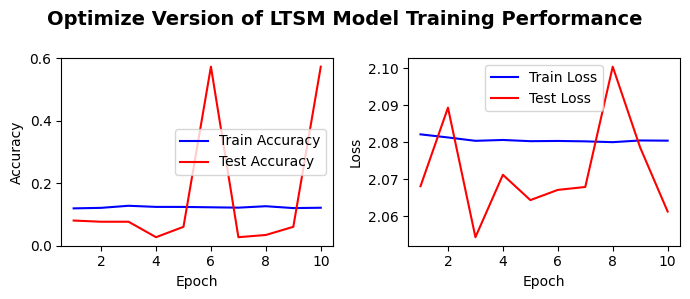

In [ ]:
# Get Accuracy & Loss Result Data
acc2 = LTSM_History.history['accuracy']
val_acc = LTSM_History.history['val_accuracy']
loss2 = LTSM_History.history['loss']
val_loss = LTSM_History.history['val_loss']

epochs = range(1,len(acc2)+1)

#Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

# Adding the main title
fig.suptitle('Optimize Version of LTSM Model Training Performance', fontsize=14, fontweight='bold')

# Adding Accuracy Plot
axes[0].plot(epochs, acc2, 'b', label='Train Accuracy')
axes[0].plot(epochs, val_acc, 'r', label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Adding Loss Plot
axes[1].plot(epochs, loss2, 'b', label='Train Loss')
axes[1].plot(epochs, val_loss, 'r', label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

#Adjusting layout for better spacing
plt.tight_layout()

#Display teh figure
plt.show()


## Clssification Report

In [ ]:
# Predict on test set
y_pred_lstm = lstm_model.predict(x_test_rnn_ltsm)
y_pred_lstm = np.argmax(y_pred_lstm, axis=1)  # Get the class predictions from the probabilities

# Classification Report for LSTM
print("LSTM Model Classification Report:")
print(classification_report(y_test_rnn_ltsm, y_pred_lstm))

625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step
LSTM Model Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1531
           1       0.57      1.00      0.73     11472
           2       0.00      0.00      0.00      1531
           3       0.00      0.00      0.00      1432
           4       0.00      0.00      0.00      1205
           5       0.00      0.00      0.00       682
           6       0.00      0.00      0.00       540
           7       0.00      0.00      0.00      1607

    accuracy                           0.57     20000
   macro avg       0.07      0.12      0.09     20000
weighted avg       0.33      0.57      0.42     20000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Confusion Matrix

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


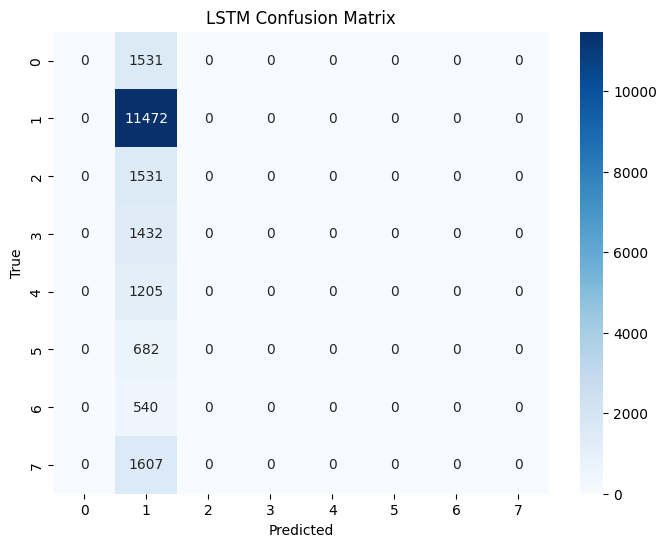

In [ ]:
# Confusion Matrix for LSTM
cm_lstm = confusion_matrix(y_test_rnn_ltsm, y_pred_lstm)

# Plot Confusion Matrix for LSTM
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test_rnn_ltsm), yticklabels=np.unique(y_test_rnn_ltsm))
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Build CNN Model

In [ ]:
# Best val_accuracy So Far: 0.9258000254631042
# Total elapsed time: 00h 18m 00s
# Best dropout rate: 0.2
# Best learning rate: 0.00018605746482849058
# Best filters: 256
# Best kernel size: 6
# Best dense_units_1: 224
# Best dense_units_2: 192
# Best dense_units_3: 64

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
import random
import numpy as np
import tensorflow as tf

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Define model
cnn_model = Sequential()

# Embedding layer (converts word indices to dense vectors)
cnn_model.add(Embedding(input_dim=10000, output_dim=128, input_length=155))

# 1D Convolutional Layer
cnn_model.add(Conv1D(filters=256, kernel_size=6, activation='relu'))

# Max Pooling Layer
cnn_model.add(MaxPooling1D(pool_size=2))

# Flatten to feed into Dense layers
cnn_model.add(Flatten())

# Add Fully Connected Layer (Input, Hidden, Output Layer)
cnn_model.add(Dense(224, activation='relu')) # Hidden Layer 1
cnn_model.add(Dropout(0.5)) # Dropout 1
cnn_model.add(Dense(192, activation='relu')) # Hidden Layer 2
cnn_model.add(Dropout(0.5)) # Dropout 2
cnn_model.add(Dense(64, activation='relu')) # Hidden Layer 3
cnn_model.add(Dropout(0.5)) # Dropout 3

cnn_model.add(Dense(8, activation='softmax'))

# Adjust Learning rate
optimizer = Adam(learning_rate=0.0002)
cnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Build Model
CNN_History = cnn_model.fit(x_train_rnn_ltsm_resampled, y_train_rnn_ltsm_resampled, epochs=5, batch_size=32, validation_data=(x_test_rnn_ltsm, y_test_rnn_ltsm))

Epoch 1/5
541/541 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.1487 - loss: 2.0557 - val_accuracy: 0.2582 - val_loss: 1.6486
Epoch 2/5
541/541 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5111 - loss: 1.2525 - val_accuracy: 0.6219 - val_loss: 0.9519
Epoch 3/5
541/541 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7613 - loss: 0.6560 - val_accuracy: 0.9026 - val_loss: 0.5832
Epoch 4/5
541/541 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8727 - loss: 0.3992 - val_accuracy: 0.9172 - val_loss: 0.3838
Epoch 5/5
541/541 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9298 - loss: 0.2675 - val_accuracy: 0.9190 - val_loss: 0.3880


# Evaluation CNN Model

## Import Library

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Learning Curve

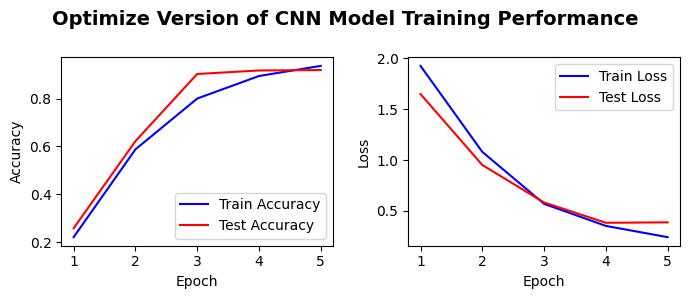

In [ ]:
# Get Accuracy & Loss Result Data
acc2 = CNN_History.history['accuracy']
val_acc = CNN_History.history['val_accuracy']
loss2 = CNN_History.history['loss']
val_loss = CNN_History.history['val_loss']

epochs = range(1,len(acc2)+1)

#Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

# Adding the main title
fig.suptitle('Optimize Version of CNN Model Training Performance', fontsize=14, fontweight='bold')

# Adding Accuracy Plot
axes[0].plot(epochs, acc2, 'b', label='Train Accuracy')
axes[0].plot(epochs, val_acc, 'r', label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Adding Loss Plot
axes[1].plot(epochs, loss2, 'b', label='Train Loss')
axes[1].plot(epochs, val_loss, 'r', label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

#Adjusting layout for better spacing
plt.tight_layout()

#Display teh figure
plt.show()




## Clssification Report

In [ ]:
# Predict on test set
y_pred_cnn = cnn_model.predict(x_test_rnn_ltsm)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)  # Get the class predictions from the probabilities

# Classification Report for CNN
print("CNN Model Classification Report:")
print(classification_report(y_test_rnn_ltsm, y_pred_cnn))

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CNN Model Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1531
           1       1.00      0.89      0.94     11472
           2       0.88      0.96      0.91      1531
           3       0.84      0.97      0.90      1432
           4       0.69      0.98      0.81      1205
           5       0.81      0.96      0.88       682
           6       0.95      0.99      0.97       540
           7       0.84      0.92      0.88      1607

    accuracy                           0.92     20000
   macro avg       0.87      0.96      0.91     20000
weighted avg       0.93      0.92      0.92     20000



## Confusion Matrix

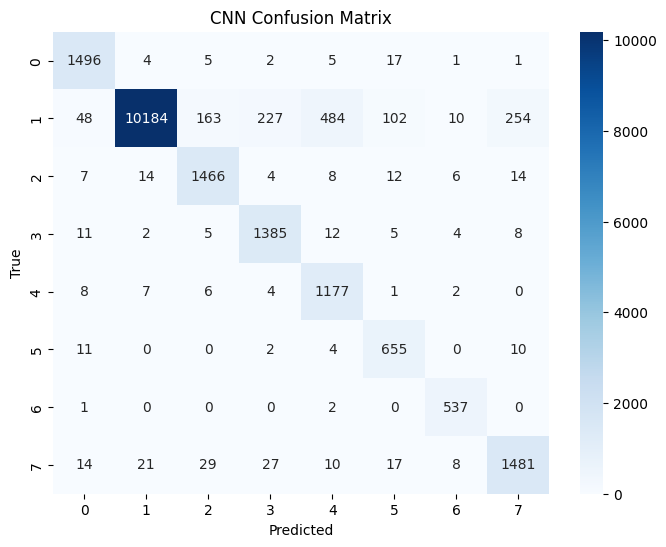

In [ ]:
# Confusion Matrix for CNN
cm_cnn = confusion_matrix(y_test_rnn_ltsm, y_pred_cnn)

# Plot Confusion Matrix for CNN
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test_rnn_ltsm), yticklabels=np.unique(y_test_rnn_ltsm))
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Build Naive Bayes Model

In [11]:
# Import necessary libraries for models
from sklearn.naive_bayes import MultinomialNB

# Build Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(x_train_nb_lr_resampled, y_train_nb_lr_resampled)

MultinomialNB()

# Evaluation Naive Bayes Model

## Import Library

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

## Learning Curve

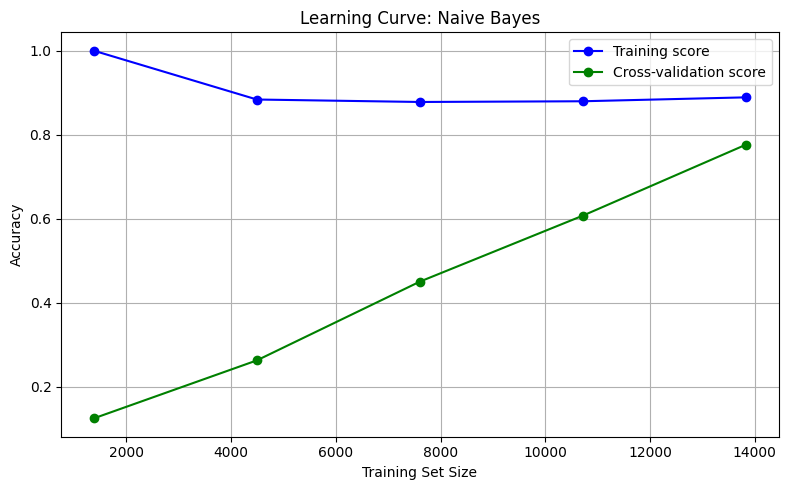

In [13]:
# Plot Learning Curve Function
def plot_learning_curve(model, X, y, model_name):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='accuracy')

    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')
    plt.title(f'Learning Curve: {model_name}')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.tight_layout()
    plt.show()

# Plot for Naive Bayes Learning Curve
plot_learning_curve(MultinomialNB(), x_train_nb_lr_resampled, y_train_nb_lr_resampled, "Naive Bayes")

## Clssification Report

In [14]:
# Naive Bayes (Classification Report)
y_pred_nb = nb_model.predict(x_test_nb_lr)
print("=== Naive Bayes ===")
print("Classification Report:\n", classification_report(y_test_nb_lr, y_pred_nb))

=== Naive Bayes ===
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.78      0.55      1531
           1       0.99      0.26      0.42     11472
           2       0.42      0.79      0.54      1531
           3       0.49      0.79      0.60      1432
           4       0.50      0.95      0.66      1205
           5       0.42      0.90      0.57       682
           6       0.22      0.98      0.35       540
           7       0.44      0.73      0.55      1607

    accuracy                           0.50     20000
   macro avg       0.49      0.77      0.53     20000
weighted avg       0.75      0.50      0.48     20000



## Confusion Matrix

Confusion Matrix:


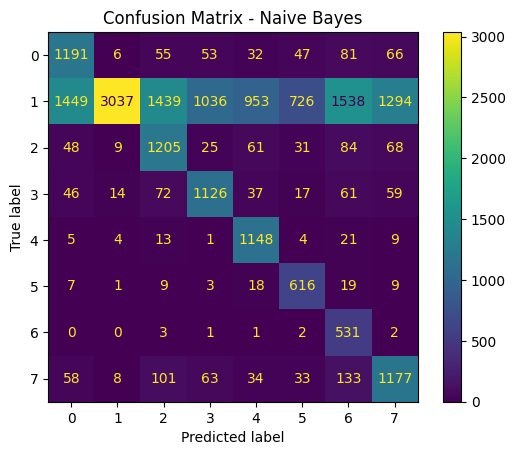

In [15]:
# Naive Bayes (Confusion Matrix Report)
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test_nb_lr, y_pred_nb)
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

# Build Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression

# Define the Logistic Regression model with the best hyperparameters
lr_model = LogisticRegression(C=10, penalty='l1', solver='saga', max_iter=1000)

# Fit the model on the training data
lr_model.fit(x_train_nb_lr_resampled, y_train_nb_lr_resampled)

C:\Users\jiunj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=10, max_iter=1000, penalty='l1', solver='saga')

# Evaluation Logistic Regression Model

## Import Library

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

## Learning Curve

C:\Users\jiunj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jiunj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jiunj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packag

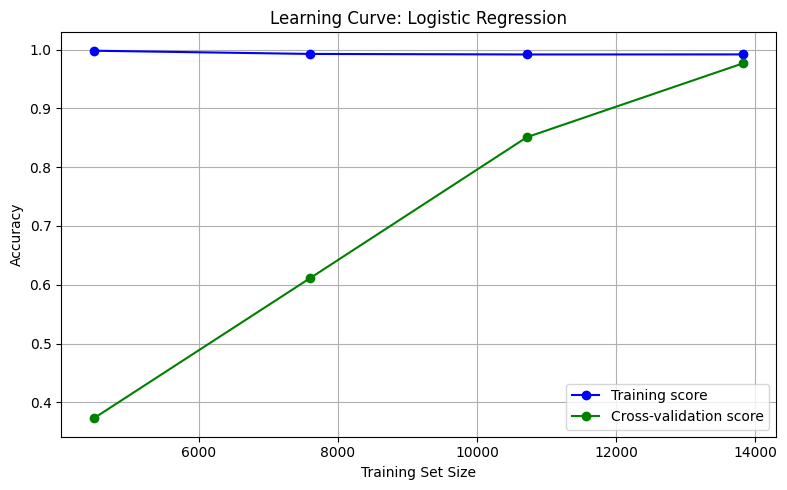

In [12]:
# Plot Learning Curve Function
def plot_learning_curve(model, X, y, model_name):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='accuracy')

    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')
    plt.title(f'Learning Curve: {model_name}')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.tight_layout()
    plt.show()

# Plot for Logistic Regression Model Learning Curve
plot_learning_curve(LogisticRegression(max_iter=1000), x_train_nb_lr_resampled, y_train_nb_lr_resampled, "Logistic Regression")


## Clssification Report & Confusion Matrix

In [13]:
# Logistic Regression (Classification Report)
y_pred_log = lr_model.predict(x_test_nb_lr)
print("=== Logistic Regression ===")
print("Classification Report:\n", classification_report(y_test_nb_lr, y_pred_log))

=== Logistic Regression ===
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1531
           1       1.00      0.95      0.97     11472
           2       0.92      0.99      0.95      1531
           3       0.92      0.99      0.95      1432
           4       0.92      1.00      0.96      1205
           5       0.93      0.99      0.96       682
           6       0.98      1.00      0.99       540
           7       0.92      0.98      0.95      1607

    accuracy                           0.97     20000
   macro avg       0.94      0.99      0.96     20000
weighted avg       0.97      0.97      0.97     20000



## Confusion Matrix

Confusion Matrix:


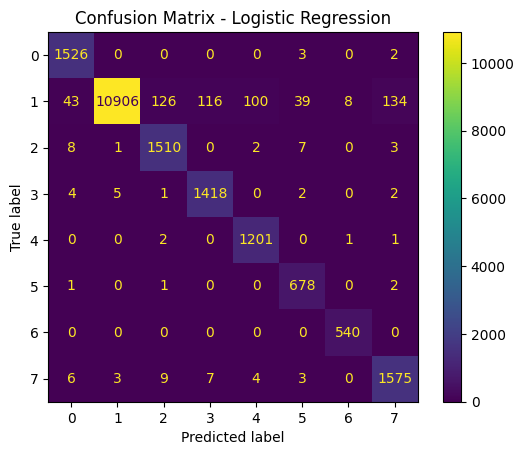

In [14]:
# Logistic Regression (Confusion Matric Report)
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test_nb_lr, y_pred_log)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Save LR Model & Vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

texts = df['review_text'].astype(str).tolist()

# Define Vectorizer
vectorizer = TfidfVectorizer(max_features=10000)

# Save vectorizer and model (Visual Stdio)
joblib.dump(vectorizer, 'TFvectorizer.pkl')
joblib.dump(lr_model, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']